In [1]:
# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

from pyDecision.algorithm.fuzzy_ahp import fuzzy_ahp_method
from pyDecision.algorithm.fuzzy_vikor import fuzzy_vikor_method

In [2]:
# ============================================================
# Load data
# ============================================================
df = pd.read_csv("Restaurant Manual Encoded.csv")

ID_col = df["Restaurant ID"]           # identifier (kept for interpretation)
y = df["Reviews"]                      # target
X = df.drop(columns=["Name","Restaurant ID", "Reviews"])

In [3]:
# ============================================================
# Feature groups
# ============================================================
num = ["Review Count"]

ord_ = [
    "Distance (km) from Yuntech", "Price Range", "Foot Traffic Level",
    "Accessibility Score", "Visibility from main road", "Storefront Size",
    "Signboard Distinctiveness", "Competition Density", "Operational Hours"
]

nom = [
    "Category",
    "Building Type",
    "Street Location Type", 
    "Surrounding Environment"
]



In [4]:
# ============================================================
# Regression model (importance extraction)
# ============================================================
preprocess = ColumnTransformer([
    ("num", RobustScaler(), num),
    ("ord", RobustScaler(), ord_),
    ("nom", OneHotEncoder(drop="first", sparse_output=False), nom)
])

model = Pipeline([
    ("prep", preprocess),
    ("reg", Ridge(alpha=1.0))
])

model.fit(X, y)

coefs = model.named_steps["reg"].coef_
names = model.named_steps["prep"].get_feature_names_out()

In [5]:
# ============================================================
# Utility matrix construction
# ============================================================
def minmax(df_):
    return (df_ - df_.min()) / (df_.max() - df_.min())

num_util = minmax(df[num])
ord_util = minmax(df[ord_])

# Nominal utilities via regression coefficients
nom_util = pd.DataFrame(index=df.index)

for c in nom:
    cols = [n for n in names if n.startswith(f"nom__{c}_")]
    values = np.zeros(len(df))
    for col in cols:
        cat = col.replace(f"nom__{c}_", "")
        values += (df[c] == cat) * coefs[list(names).index(col)]
    nom_util[c] = values

nom_util = minmax(nom_util)

In [6]:
# ============================================================
# Final decision matrix
# ============================================================
decision_df = pd.concat([num_util, ord_util, nom_util], axis=1)
criteria = decision_df.columns.tolist()


In [7]:
# ============================================================
# Criterion types
# ============================================================
criteria_type = [
    "cost" if c in ["Distance (km) from Yuntech", "Price Range", "Competition Density"]
    else "benefit"
    for c in criteria
]


In [8]:
# ============================================================
# Regression → criterion weights
# ============================================================
crit_w = defaultdict(float)

for n, c in zip(names, coefs):
    feat = n.split("__", 1)[1]
    for cr in criteria:
        if feat == cr or feat.startswith(cr + "_"):
            crit_w[cr] += abs(c)
            break

w_ml = np.array([crit_w[c] for c in criteria])
w_ml /= w_ml.sum()

In [9]:
# ============================================================
# FAHP
# ============================================================
n = len(criteria)
pcm = np.array([[[w_ml[i] / w_ml[j]] * 3 for j in range(n)] for i in range(n)])

fahp = fuzzy_ahp_method(pcm)[0]
w_fahp = np.array([(l + m + u) / 3 for l, m, u in fahp])
w_fahp /= w_fahp.sum()

fuzzy_weights = [[
    [0.9 * w, w, 1.1 * w] for w in w_fahp
]]

a1: 4.0
a2: 5.0
a3: 20.0
a4: 25.0
a5: 24.0
a6: 14.0
a7: 3.0
a8: 1.0
a9: 11.0
a10: 23.0
a11: 22.0
a12: 10.0
a13: 16.0
a14: 17.0
a15: 9.0
a16: 18.0
a17: 2.0
a18: 12.0
a19: 19.0
a20: 21.0
a21: 6.0
a22: 15.0
a23: 13.0
a24: 7.0
a25: 8.0
a26: 26.0


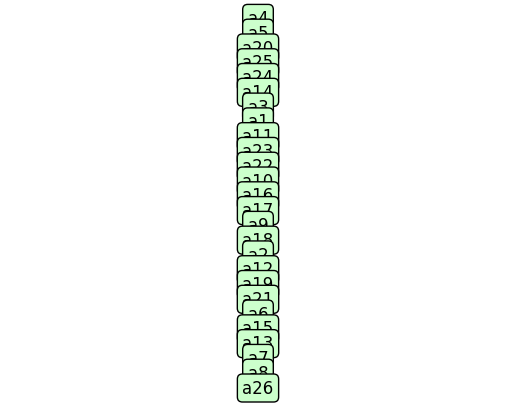

In [10]:
# ============================================================
# FVIKOR decision matrix
# ============================================================
decision_matrix = np.array([
    [[0.9 * v, v, 1.1 * v] for v in row]
    for row in decision_df.values
])

_, _, Q, ranking = fuzzy_vikor_method(
    decision_matrix, fuzzy_weights, criteria_type
)

In [11]:
# ============================================================
# Defuzzify & align
# ============================================================
Q = np.asarray(Q, dtype=float)
if Q.ndim == 2:
    Q = Q.mean(axis=1)

ranking = np.asarray(ranking)
if ranking.ndim == 2:
    ranking = ranking[:, -1]

results = decision_df.copy()
results["Restaurant ID"] = ID_col
results["Q"] = Q
results["Rank"] = ranking

In [12]:
# ============================================================
# Optimal restaurant
# ============================================================
best_idx = results["Q"].idxmin()
optimal = results.loc[best_idx]

print("\nOptimal restaurant alternative (UTILITY PROFILE):")
print(optimal)


Optimal restaurant alternative (UTILITY PROFILE):
Review Count                  0.050847
Distance (km) from Yuntech    0.333333
Price Range                        0.0
Foot Traffic Level                 0.0
Accessibility Score                1.0
Visibility from main road          0.5
Storefront Size                    0.0
Signboard Distinctiveness          1.0
Competition Density                1.0
Operational Hours             0.666667
Category                           1.0
Building Type                      0.0
Street Location Type          0.644967
Surrounding Environment            1.0
Restaurant ID                     R008
Q                              0.67867
Rank                          0.357339
Name: 7, dtype: object


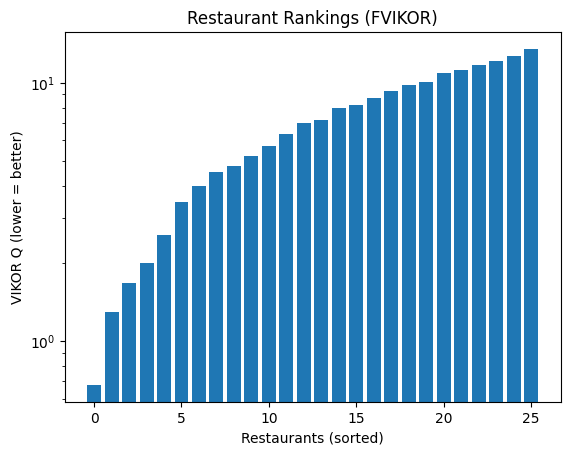

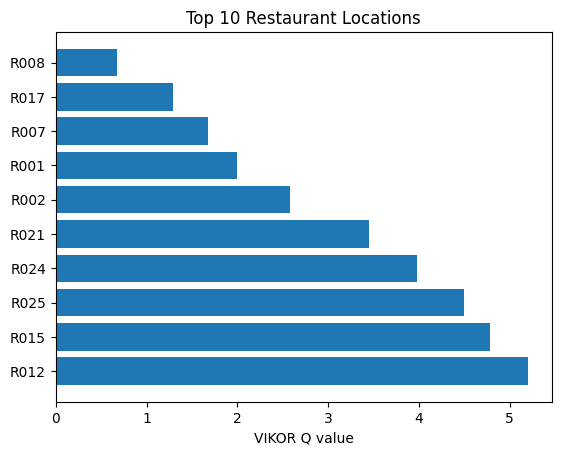

In [ ]:
# ============================================================
# Visualization: Restaurant rankings
# ============================================================
ranked = results.sort_values("Q")

plt.figure()
plt.bar(range(len(ranked)), ranked["Q"])
plt.xlabel("Restaurants (sorted)")
plt.ylabel("VIKOR Q (lower = better)")
plt.yscale("log")
plt.title("Restaurant Rankings (FVIKOR)")
plt.show()

# Top 10
top10 = ranked.head(10)

plt.figure()
plt.barh( top10["Restaurant ID"], top10["Q"])
plt.gca().invert_yaxis()
plt.xlabel("VIKOR Q value")
plt.xscale("log")
plt.title("Top 10 Restaurant Locations")
plt.show()


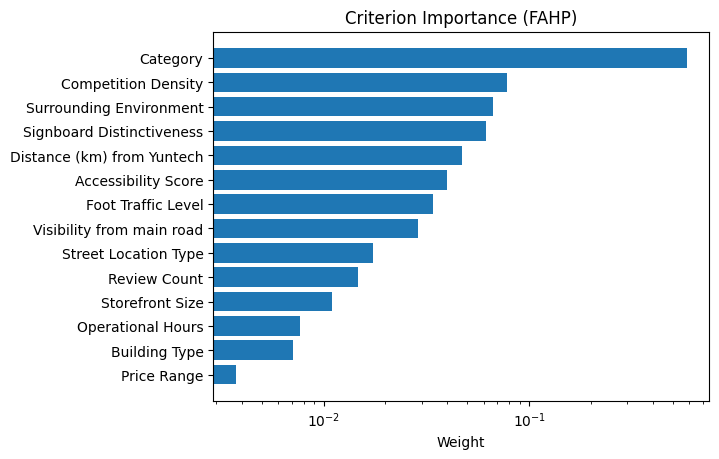

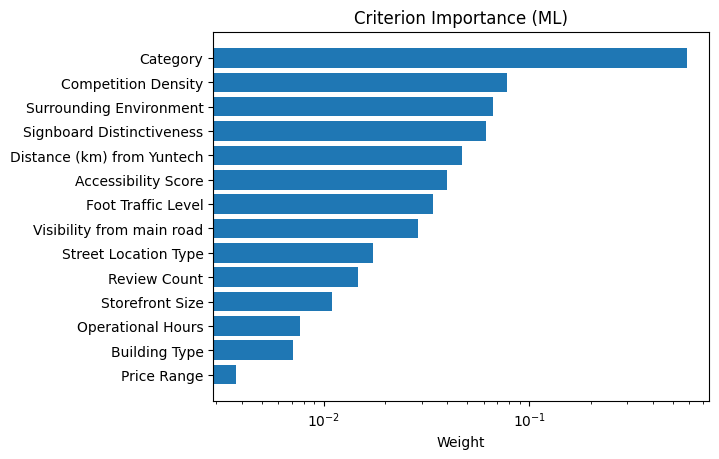

In [16]:
# ============================================================
# Visualization: Criterion importance
# ============================================================
importance_df = pd.DataFrame({
    "Criterion": criteria,
    "ML Weight (|β|)": w_ml,
    "FAHP Weight": w_fahp
}).sort_values("FAHP Weight")

plt.figure()
plt.barh(importance_df["Criterion"], importance_df["FAHP Weight"])
plt.xlabel("Weight")
plt.xscale("log")
plt.title("Criterion Importance (FAHP)")
plt.show()

plt.figure()
plt.barh(importance_df["Criterion"], importance_df["ML Weight (|β|)"])
plt.xlabel("Weight")
plt.xscale("log")
plt.title("Criterion Importance (ML)")
plt.show()